#### Para execução do código extraia os dados para a pasta Data.


# Importações e organização dos dados

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn.metrics import f1_score, make_scorer, confusion_matrix, silhouette_score


In [102]:
#variáveis
meta_data_path = 'Data/sinais.csv'
data_folder = 'Data/Sinais/'

random_state = 12

#tratamento dos keypoints
reference_kp_ids = [23, 24]   # todas as coordenadas dos keypoints vão ser recalculadas relativamente à posição média destes keypoints
visibility_threshold = 0.1    # se a visibilidade de um keypoint for menor que este valor, o keypoint é ignorado

n_segments_temporal_embedding = 15


pca_explainability = 0.95

kmeans_range = range(2, 40)
use_elbow_method = True    # se True, o k é escolhido pelo método do cotovelo; se False, é usado o valor definido em manually_chosen_k
manually_chosen_k =25

kmeans_iterations = 20 


In [130]:
#carregando os Meta-dados
meta_data = pd.read_csv(meta_data_path)

#verificando valores nulos
meta_data.isnull().sum()


file_name       1
width           0
height          0
duration_sec    0
num_frames      0
sinal           0
interprete      0
dtype: int64

In [131]:
#removendo valores nulos
meta_data = meta_data.dropna()

"""
    - Como vou estabelecer um keypoint de referência, as dimensões do vídeo deixam de importar.
    - Com o objetivo de generalizar os modelos, o interprete também não deve ser levado em consideração.
    - Já que o frame rate é fixo em 30 fps para todos os vídeos, número de frames e duração são redundantes.
"""
meta_data = meta_data.drop(columns=['width', 'height', 'interprete', 'duration_sec'])

#carregando dados
data = []
for index, row in meta_data.iterrows():
    file_path = data_folder + row['file_name']
    
    with open(file_path, 'r') as f:
        json_data = json.load(f)
    
    signal_data = {
        'label': row['sinal'],
        'num_frames': row['num_frames'],
        'frames': json_data['frames']
    }
    data.append(signal_data)

data[0]['frames'][0:5]

[{'frame': 0,
  'keypoints': [{'id': 0, 'x': 417, 'y': 183, 'z': -1.41, 'visibility': 1.0},
   {'id': 1, 'x': 443, 'y': 153, 'z': -1.34, 'visibility': 1.0},
   {'id': 2, 'x': 455, 'y': 153, 'z': -1.34, 'visibility': 1.0},
   {'id': 3, 'x': 465, 'y': 154, 'z': -1.34, 'visibility': 1.0},
   {'id': 4, 'x': 400, 'y': 154, 'z': -1.33, 'visibility': 1.0},
   {'id': 5, 'x': 387, 'y': 155, 'z': -1.33, 'visibility': 1.0},
   {'id': 6, 'x': 374, 'y': 156, 'z': -1.33, 'visibility': 1.0},
   {'id': 7, 'x': 487, 'y': 170, 'z': -0.86, 'visibility': 1.0},
   {'id': 8, 'x': 362, 'y': 173, 'z': -0.82, 'visibility': 1.0},
   {'id': 9, 'x': 446, 'y': 220, 'z': -1.23, 'visibility': 1.0},
   {'id': 10, 'x': 393, 'y': 222, 'z': -1.22, 'visibility': 1.0},
   {'id': 11, 'x': 602, 'y': 386, 'z': -0.57, 'visibility': 1.0},
   {'id': 12, 'x': 261, 'y': 381, 'z': -0.51, 'visibility': 1.0},
   {'id': 13, 'x': 672, 'y': 639, 'z': -0.59, 'visibility': 1.0},
   {'id': 14, 'x': 200, 'y': 636, 'z': -0.52, 'visibility':

# Pré-processamento dos keypoints

In [105]:
#verificando se todos os frames possuem 33 keypoints                
cout = 0
for signal in data:
    for frame in signal['frames']:
        if len(frame['keypoints']) != 33:
            cout += 1
            print(len(frame['keypoints']))
print(f'quantidade de frames com menos de 33 kp: {cout}')

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
quantidade de frames com menos de 33 kp: 18


In [106]:
# Removendo frames que não possuem 33 keypoints
for signal in data:
    frames_filtrados = [frame for frame in signal['frames'] if len(frame['keypoints']) == 33]
    signal['frames'] = frames_filtrados
    signal['num_frames'] = len(frames_filtrados)

In [107]:
"""
    Como dito antes vamos definir um ponto de referência e então calcular o X, Y e Z de todos os keypoints a partir desse ponto de referência,
    dessa forma alem de não dependermos da altura e largura da imagem, a posição de cada keypoint passa a ser relativa ao corpo do interprete,
    tornando a representação mais consistente entre vídeos.
"""
def pre_process_keypoints(data):
    for signal in data:
        for frame in signal['frames']:
            
            # Calculo do ponto de referência médio
            ref_points = [frame['keypoints'][i] for i in reference_kp_ids]
            ref_x = np.mean([p['x'] for p in ref_points])
            ref_y = np.mean([p['y'] for p in ref_points])
            ref_z = np.mean([p['z'] for p in ref_points])
            
            
            # Ajuste dos keypoints em relação ao ponto de referência
            for kp in frame['keypoints']:
                kp['x'] -= ref_x
                kp['y'] -= ref_y
                kp['z'] -= ref_z
                
pre_process_keypoints(data)


In [108]:
"""
    Calcula média, mínimo e máximo de visibilidade para cada keypoint
"""

def compute_visibility_stats(data, n_keypoints=33):
   
    visibility_sums = np.zeros(n_keypoints)
    counts = np.zeros(n_keypoints)
    visibility_min = np.full(n_keypoints, np.inf)
    visibility_max = np.full(n_keypoints, -np.inf)
    
    for signal in data:
        for frame in signal['frames']:
            for kp in frame['keypoints']:
                id = kp['id']
                visibility = kp['visibility']
                visibility_sums[id] += visibility
                counts[id] += 1
                visibility_min[id] = min(visibility_min[id], visibility)
                visibility_max[id] = max(visibility_max[id], visibility)

    mean_visibility = visibility_sums / counts
    return mean_visibility, visibility_min, visibility_max
    

mean_vis, min_vis, max_vis = compute_visibility_stats(data)


#Analise da visibilidade dos keypoints
kp_to_keep = [i for i, visibility in enumerate(mean_vis) if visibility >= visibility_threshold]


#exibindo resultados
for i in range(33):
    print(f'Keypoint {i}: Mean={mean_vis[i]:.3f}, Min={min_vis[i]:.3f}, Max={max_vis[i]:.3f}')
    
print(f'Keypoints a serem mantidos (visibilidade média >= {visibility_threshold}): {kp_to_keep}')

Keypoint 0: Mean=1.000, Min=0.990, Max=1.000
Keypoint 1: Mean=1.000, Min=0.990, Max=1.000
Keypoint 2: Mean=1.000, Min=0.990, Max=1.000
Keypoint 3: Mean=1.000, Min=0.990, Max=1.000
Keypoint 4: Mean=1.000, Min=0.990, Max=1.000
Keypoint 5: Mean=1.000, Min=0.990, Max=1.000
Keypoint 6: Mean=1.000, Min=0.990, Max=1.000
Keypoint 7: Mean=1.000, Min=0.990, Max=1.000
Keypoint 8: Mean=1.000, Min=0.990, Max=1.000
Keypoint 9: Mean=1.000, Min=0.990, Max=1.000
Keypoint 10: Mean=1.000, Min=0.990, Max=1.000
Keypoint 11: Mean=1.000, Min=1.000, Max=1.000
Keypoint 12: Mean=1.000, Min=0.990, Max=1.000
Keypoint 13: Mean=0.998, Min=0.890, Max=1.000
Keypoint 14: Mean=0.997, Min=0.900, Max=1.000
Keypoint 15: Mean=0.987, Min=0.210, Max=1.000
Keypoint 16: Mean=0.980, Min=0.150, Max=1.000
Keypoint 17: Mean=0.969, Min=0.120, Max=1.000
Keypoint 18: Mean=0.952, Min=0.090, Max=1.000
Keypoint 19: Mean=0.971, Min=0.150, Max=1.000
Keypoint 20: Mean=0.956, Min=0.100, Max=1.000
Keypoint 21: Mean=0.971, Min=0.150, Max=1.00

In [109]:
# remoção dos keypoints com visibilidade baixa
for signal in data:
    for frame in signal['frames']:
        frame['keypoints'] = [kp for kp in frame['keypoints'] if kp['id'] in kp_to_keep]

print(f'total keypoints: {len(data[0]['frames'][0]['keypoints'])}')

total keypoints: 27


# Preparação dos embeddings

In [110]:
"""
    Para não perder muita informação temporal, vamos dividir os frames em segmentos e calcular 
    a média dos keypoints em cada segmento.

"""

def temporal_embedding(data, n_segments):
    for signal in data:
        n_frames = signal['num_frames']
        segment_size = n_frames // n_segments
        embedded_frames = []
        # Divide os frames em segmentos temporais
        for i in range(n_segments):
            start = i * segment_size
            # O último segmento pega até o final
            end = (i + 1) * segment_size if i < n_segments - 1 else n_frames
            
            segment = signal['frames'][start:end]
            
            # soma dos dados de todos os frames do segmento
            frames_sum = {
                'frame': i,
                'keypoints': [{'id': kp['id'], 'x': 0, 'y': 0, 'z': 0, 'visibility': 0} for kp in segment[0]['keypoints']]
            }
            for frame in segment:
                for i, kp in enumerate(frame['keypoints']):
                    frames_sum['keypoints'][i]['x'] += kp['x']
                    frames_sum['keypoints'][i]['y'] += kp['y']
                    frames_sum['keypoints'][i]['z'] += kp['z']
                    frames_sum['keypoints'][i]['visibility'] += kp['visibility']
                    
            # Calcula a média dos keypoints para o segmento
            avg_frame = {
                'frame': frames_sum['frame'],
                'keypoints': [{'id': kp['id'],
                               'x': kp['x'] / len(segment),
                               'y': kp['y'] / len(segment),
                               'z': kp['z'] / len(segment),
                               'visibility': kp['visibility'] / len(segment)} for kp in frames_sum['keypoints']]
            }
            # Adiciona o frame médio à lista de embeddings
            embedded_frames.append(avg_frame)
        signal['frames'] = embedded_frames
        signal['num_frames'] = len(embedded_frames)
    

temporal_embedding(data, n_segments_temporal_embedding)


# Converção para data frame e PCA

In [111]:
#converção data para DataFrame
for signal in data:
    features = {}

    for frame in signal['frames']:
        for kp in frame['keypoints']:
            for cord in ['x', 'y', 'z', 'visibility']:
                features[f'f_{frame["frame"]}_kp_{kp["id"]}_{cord}'] = kp[cord]
    signal['features'] = features
    
df = pd.DataFrame([{'label': signal['label'], **signal['features']} for signal in data])
    
df

,label,f_0_kp_0_x,f_0_kp_0_y,f_0_kp_0_z,f_0_kp_0_visibility,f_0_kp_1_x,f_0_kp_1_y,f_0_kp_1_z,f_0_kp_1_visibility,f_0_kp_2_x,...,f_14_kp_24_z,f_14_kp_24_visibility,f_14_kp_25_x,f_14_kp_25_y,f_14_kp_25_z,f_14_kp_25_visibility,f_14_kp_26_x,f_14_kp_26_y,f_14_kp_26_z,f_14_kp_26_visibility
0,Adição,-8.666667,-693.000000,-1.275000,1.0,16.111111,-723.555556,-1.201667,1.0,29.000000,...,0.012000,0.980000,125.400000,369.150000,-0.256000,0.309000,-85.300000,364.250000,0.000000,0.216000
1,Adição,-18.444444,-711.722222,-1.418333,1.0,5.444444,-741.500000,-1.340556,1.0,18.444444,...,0.029412,0.979412,133.205882,371.676471,-0.197059,0.260588,-83.617647,371.558824,0.120000,0.170588
2,Adição,-17.375000,-703.687500,-1.345625,1.0,6.875000,-734.437500,-1.274375,1.0,19.625000,...,0.035476,0.968571,133.357143,362.261905,-0.186429,0.203810,-77.833333,364.738095,0.138810,0.133810
3,Adição,-17.055556,-705.777778,-1.370000,1.0,7.833333,-737.555556,-1.297778,1.0,22.388889,...,0.041364,0.968636,129.022727,364.863636,-0.186818,0.301818,-81.522727,365.409091,0.119091,0.215909
4,Adição,-19.388889,-712.000000,-1.412222,1.0,6.388889,-743.666667,-1.336667,1.0,20.388889,...,0.060000,0.967500,130.416667,369.458333,-0.224167,0.334167,-81.500000,372.875000,0.145000,0.245833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,Ângulo,-13.666667,-411.166667,-1.546667,1.0,1.111111,-432.055556,-1.475556,1.0,8.222222,...,-0.022778,1.000000,56.333333,213.833333,0.009444,0.561111,-58.000000,208.611111,0.385000,0.331111
2497,Ângulo,-10.312500,-411.000000,-1.488750,1.0,4.062500,-430.500000,-1.417500,1.0,11.062500,...,-0.012857,1.000000,51.285714,213.714286,-0.010714,0.550000,-61.785714,206.714286,0.382143,0.323571
2498,Ângulo,-13.750000,-408.875000,-1.559375,1.0,1.250000,-428.875000,-1.490625,1.0,8.625000,...,-0.010000,1.000000,50.550000,211.050000,-0.024000,0.499000,-59.350000,204.250000,0.352000,0.300000
2499,Ângulo,-11.312500,-412.187500,-1.641875,1.0,2.937500,-432.437500,-1.568125,1.0,10.187500,...,-0.001000,1.000000,56.050000,213.300000,-0.193000,0.504000,-54.450000,208.600000,0.201000,0.334000


In [112]:
# ANÁLISE DO DATAFRAME

print("=" * 50)
print("INFORMAÇÕES BÁSICAS DO DATASET")
print("=" * 50)

print(f"Shape do DataFrame: {df.shape}")
print(f"Número de amostras: {df.shape[0]}")
print(f"Número de features: {df.shape[1] - 1}")
print(f"Memória utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "=" * 50)
print("DISTRIBUIÇÃO DAS CLASSES")
print("=" * 50)

print(df['label'].value_counts())
print(f"\nNúmero de classes únicas: {df['label'].nunique()}")



INFORMAÇÕES BÁSICAS DO DATASET
Shape do DataFrame: (2501, 1621)
Número de amostras: 2501
Número de features: 1620
Memória utilizada: 31.06 MB

DISTRIBUIÇÃO DAS CLASSES
label
Adição              101
Aluno               101
Antropologia        100
Apontador           100
Apostila            100
Biologia            100
Capítulo            100
Classe              100
Coerência           100
Ensinar             100
Coesão              100
Colega              100
Conceito            100
Contexto            100
Curso               100
Dicionário          100
Disciplina          100
Física              100
Escola              100
Estudar             100
Filosofia           100
História            100
Geografia           100
Ângulo              100
Bolsa de Estudos     99
Name: count, dtype: int64

Número de classes únicas: 25


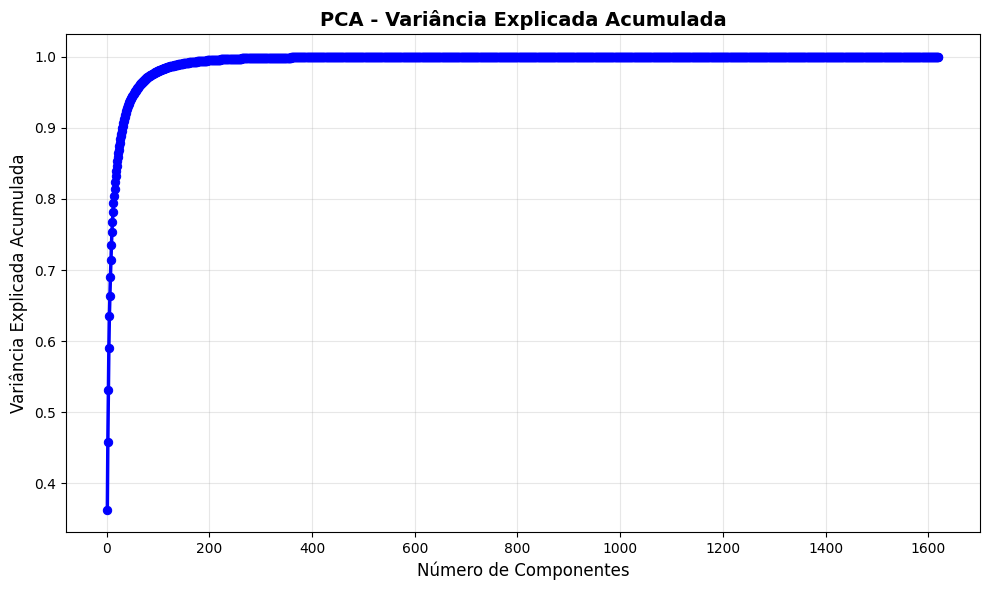

In [113]:
"""
    Tendo em vista a quantidade de features, vamos aplicar PCA para reduzir a dimensionalidade.
"""
# Separação de X e y
X = df.drop(columns=['label'])
y = df['label']

X_scaled = StandardScaler().fit_transform(X)

test_pca = PCA(random_state=random_state)
X_pca = test_pca.fit_transform(X_scaled)

# Calcula a variância explicada acumulada pelos componentes principais
explained_variance = test_pca.explained_variance_ratio_.cumsum()

pca_df = pd.DataFrame({
    'Componente': range(1, len(explained_variance) + 1),
    'Variância_Explicada': explained_variance
})

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=pca_df, x='Componente', y='Variância_Explicada', 
             marker='o', linewidth=2.5, markersize=6, color='blue', markeredgecolor='blue')
plt.xlabel("Número de Componentes", fontsize=12)
plt.ylabel("Variância Explicada Acumulada", fontsize=12)
plt.title("PCA - Variância Explicada Acumulada", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [114]:
"""
    Pode-se observar que conseguimos uma explicabilidade proxima de 100% com menos de 200 componentes. 
"""

for exp_var in np.arange(0.95, 0.991, 0.01):
    pca_tmp = PCA(n_components=exp_var, random_state=random_state)
    pca_tmp.fit(X_scaled)
    print(f'Explicabilidade: {exp_var:.2f} -> Número de componentes: {pca_tmp.n_components_}')

Explicabilidade: 0.95 -> Número de componentes: 54
Explicabilidade: 0.96 -> Número de componentes: 64
Explicabilidade: 0.97 -> Número de componentes: 78
Explicabilidade: 0.98 -> Número de componentes: 99
Explicabilidade: 0.99 -> Número de componentes: 143


In [115]:
# Com 95% consegue-se uma grande redução de dimensionalidade sem muita perda de informação

pca = PCA(n_components=pca_explainability, random_state=random_state)

# Análise Supervisionada

In [116]:
# Codificação dos labels para que f1_score consiga interpretar
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#scoring
scoring = make_scorer(f1_score, average='macro', zero_division=0)

#definição kfold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

#definição dos pipelines
preprocessing = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', pca)
])

models = {
    "Random_forest": Pipeline([
        ('preprocessing', preprocessing),
        ('clf', RandomForestClassifier(random_state=random_state))
    ]),
       

    "KNN": Pipeline([
        ('preprocessing', preprocessing),
        ('clf', KNeighborsClassifier())
    ]),

    "MPL": Pipeline([
        ('preprocessing', preprocessing),
        ('clf', MLPClassifier(max_iter=500, random_state=random_state))
    ])}

#score dos modelos

scores = pd.DataFrame({
    'Random_forest': cross_val_score(models['Random_forest'], X, y_encoded, cv=cv, n_jobs=-1, scoring=scoring),
    'KNN': cross_val_score(models['KNN'], X, y_encoded, cv=cv, n_jobs=-1, scoring=scoring),
    'MPL': cross_val_score(models['MPL'], X, y_encoded, cv=cv, n_jobs=-1, scoring=scoring)
})



# Avaliação dos modelos supervisionados

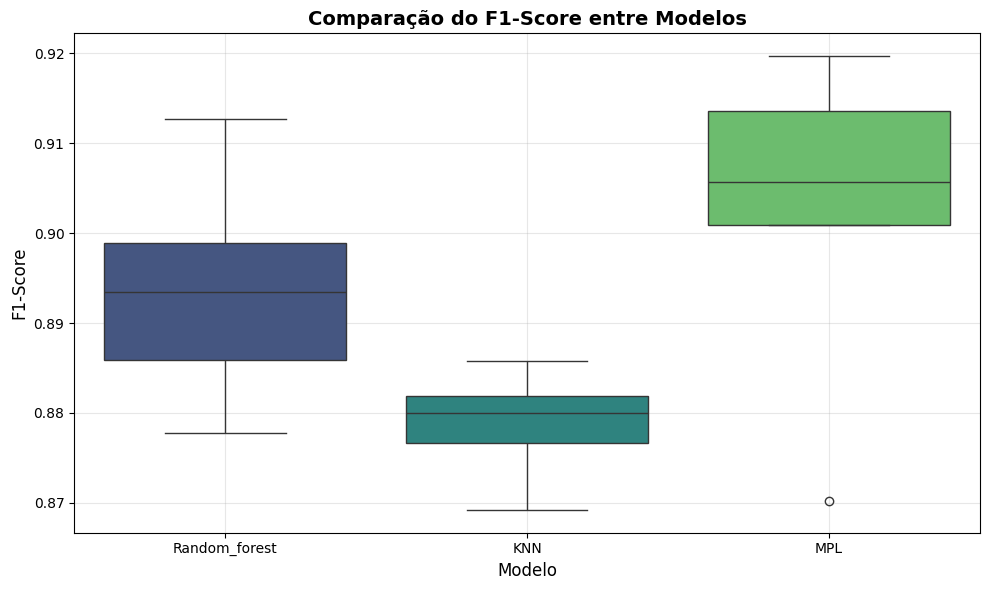

MÉDIA E DESVIO PADRÃO DO F1-SCORE
      Random_forest       KNN       MPL
mean       0.893717  0.878708  0.902013
std        0.013252  0.006241  0.019177


In [117]:
# Reformatando o DataFrame
scores_melted = scores.melt(var_name='Modelo', value_name='F1-Score')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Modelo', y='F1-Score', hue='Modelo', data=scores_melted, palette='viridis', legend=False)
plt.title('Comparação do F1-Score entre Modelos', fontsize=14, fontweight='bold')
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Médias e desvio padrão
print("=" * 50)
print("MÉDIA E DESVIO PADRÃO DO F1-SCORE")
print("=" * 50)
print(scores.agg(['mean', 'std']))


In [118]:
# Predições de cada modelo
y_pred_rf = cross_val_predict(models['Random_forest'], X, y_encoded, cv=cv, n_jobs=-1,)
y_pred_knn = cross_val_predict(models['KNN'], X, y_encoded, cv=cv, n_jobs=-1)
y_pred_mpl = cross_val_predict(models['MPL'], X, y_encoded, cv=cv, n_jobs=-1)

# Matrizes de confusão
cm_rf = confusion_matrix(y_encoded, y_pred_rf)
cm_knn = confusion_matrix(y_encoded, y_pred_knn)
cm_mpl = confusion_matrix(y_encoded, y_pred_mpl)

# Nomes das classes
class_names = label_encoder.classes_


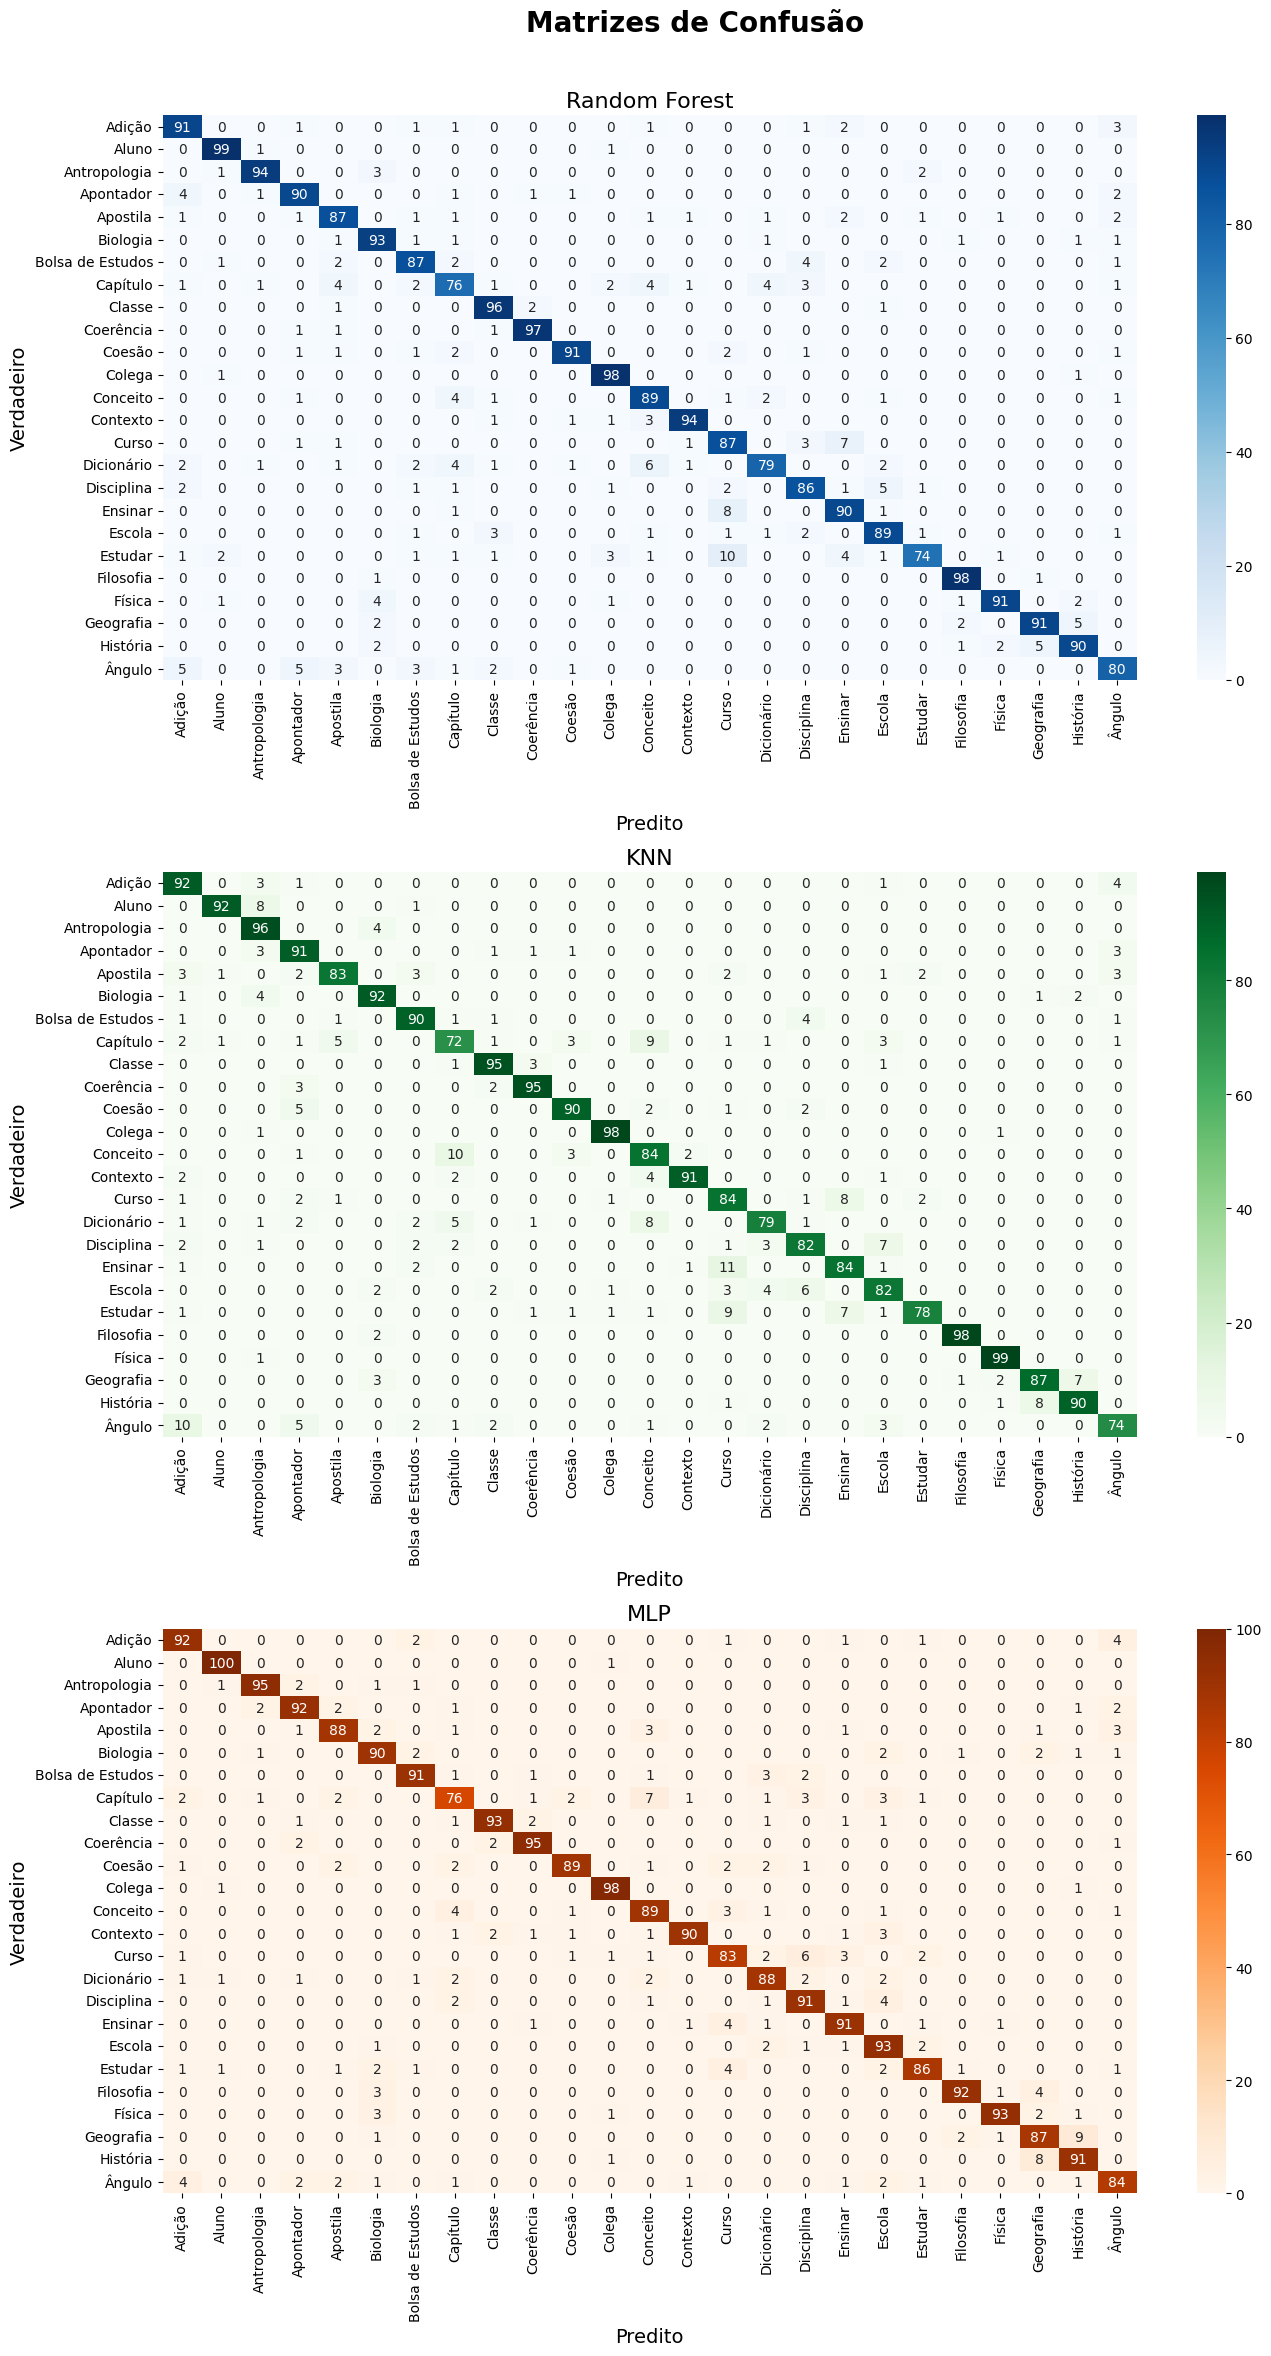

In [119]:

''' 
    Plotando as matrizes de confusão
'''
fig, axes = plt.subplots(3, 1, figsize=(14, 24))
fig.suptitle('Matrizes de Confusão', fontsize=20, fontweight='bold')

# Random Forest
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title('Random Forest', fontsize=16)
axes[0].set_xlabel('Predito', fontsize=14)
axes[0].set_ylabel('Verdadeiro', fontsize=14)

# KNN
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title('KNN', fontsize=16)
axes[1].set_xlabel('Predito', fontsize=14)
axes[1].set_ylabel('Verdadeiro', fontsize=14)

# MLP
sns.heatmap(cm_mpl, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=class_names, yticklabels=class_names)
axes[2].set_title('MLP', fontsize=16)
axes[2].set_xlabel('Predito', fontsize=14)
axes[2].set_ylabel('Verdadeiro', fontsize=14)


plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# Análise não supervisionada

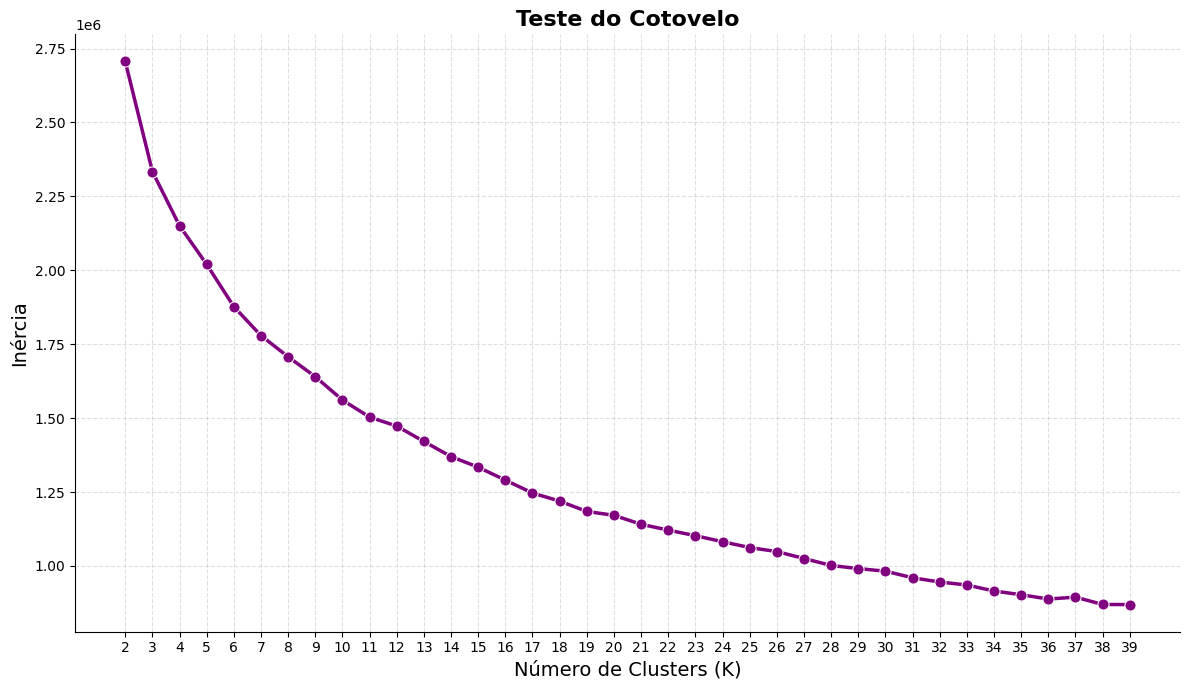

In [120]:
# Aplicando o pré-processamento nos dados
X_processed = preprocessing.fit_transform(X)

inertia = []

#K-means para diferentes valores de K
for k in kmeans_range:
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    kmeans.fit(X_processed)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(12, 7))
sns.lineplot(x=list(kmeans_range), y=inertia, marker='o', linewidth=2.5, markersize=8, color='purple')
plt.title('Teste do Cotovelo', fontsize=16, fontweight='bold')
plt.xlabel('Número de Clusters (K)', fontsize=14)
plt.ylabel('Inércia', fontsize=14)
plt.xticks(kmeans_range)
plt.grid(True, alpha=0.4, linestyle='--')
sns.despine()
plt.tight_layout()
plt.show()


In [121]:
def find_best_k(inertia, k_range, threshold=0.05):
   # diferença relativa entre as inércias consecutivas
    diffs = np.diff(inertia) / inertia[:-1]

    for i, diff in enumerate(diffs):
        if abs(diff) < threshold:
            return list(k_range)[i+1]
    # Se não encontrar, retorna o maior k
    return list(k_range)[-1]

#definição do valor de k
if use_elbow_method:
    chosen_k = find_best_k(inertia, kmeans_range, threshold=0.05)
else:
    chosen_k = manually_chosen_k
print(f'Número ideal de clusters (K) encontrado: {chosen_k}')

Número ideal de clusters (K) encontrado: 8


In [122]:
# K-means com o K escolhido
kmeans_final = KMeans(n_clusters=chosen_k, random_state=random_state, n_init=kmeans_iterations)
clusters_kmeans = kmeans_final.fit_predict(X_processed)

# Clustering hierárquico (Ward)
ward = AgglomerativeClustering(n_clusters=chosen_k, linkage='ward')
clusters_ward = ward.fit_predict(X_processed)

# Clustering hierárquico (Average)
average = AgglomerativeClustering(n_clusters=chosen_k, linkage='average')
clusters_average = average.fit_predict(X_processed)

In [123]:
print("=" * 60)
print("AVALIAÇÃO DOS ALGORITMOS - SILHOUETTE SCORE")
print("=" * 60)

# Silhouette Score de cada método
silhouette_kmeans = silhouette_score(X_processed, clusters_kmeans)
silhouette_ward = silhouette_score(X_processed, clusters_ward)
silhouette_average = silhouette_score(X_processed, clusters_average)

print(f"Silhouette Score - K-means: {silhouette_kmeans:.4f}")
print(f"Silhouette Score - Hierárquico (Ward): {silhouette_ward:.4f}")
print(f"Silhouette Score - Hierárquico (Average): {silhouette_average:.4f}")

# Determinando o melhor método
scores = {
    'K-means': silhouette_kmeans,
    'Hierárquico (Ward)': silhouette_ward,
    'Hierárquico (Average)': silhouette_average
}

melhor_metodo = max(scores, key=scores.get)
print(f"\nMelhor método baseado no Silhouette Score: {melhor_metodo} ({scores[melhor_metodo]:.4f})")

AVALIAÇÃO DOS ALGORITMOS - SILHOUETTE SCORE
Silhouette Score - K-means: 0.1849
Silhouette Score - Hierárquico (Ward): 0.2012
Silhouette Score - Hierárquico (Average): 0.6156

Melhor método baseado no Silhouette Score: Hierárquico (Average) (0.6156)


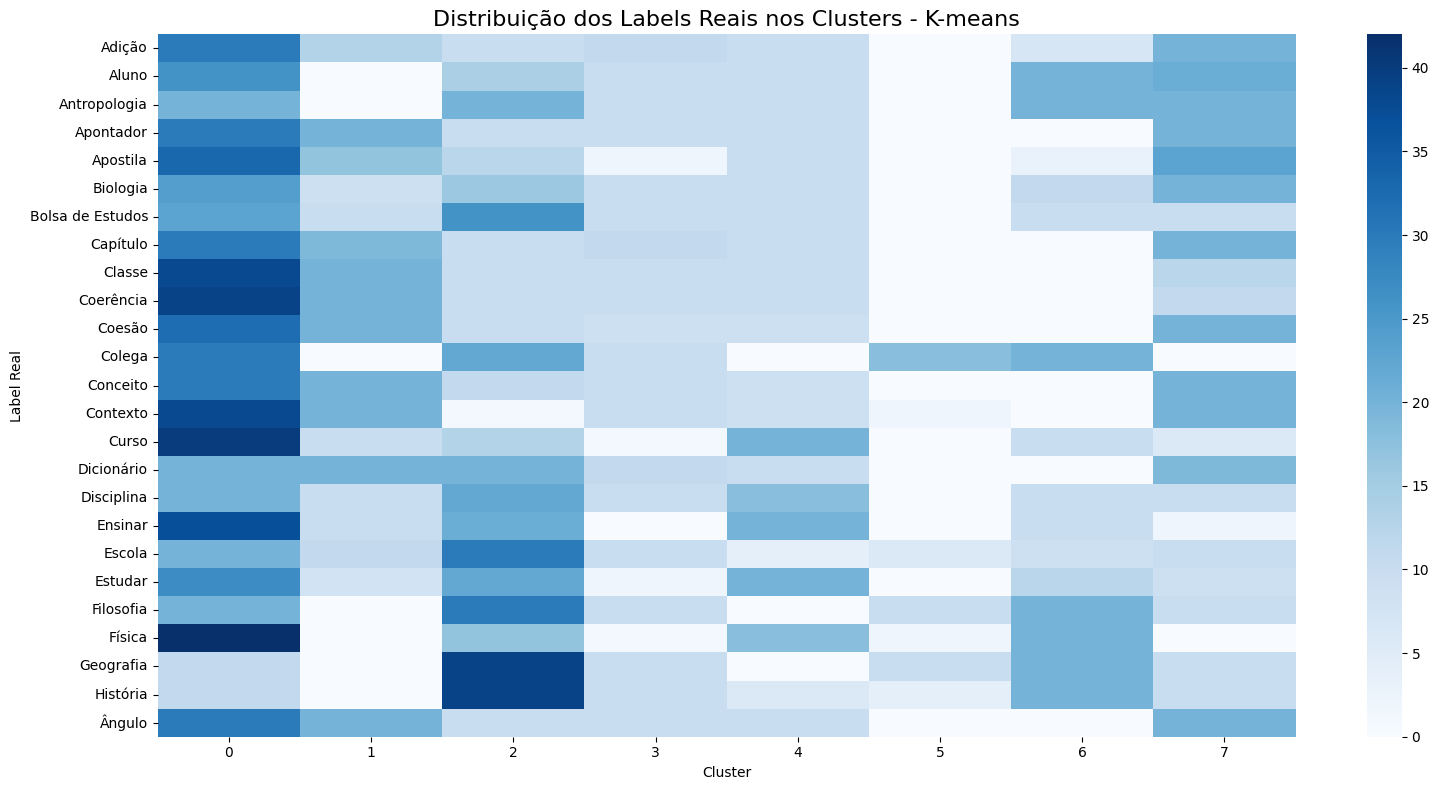

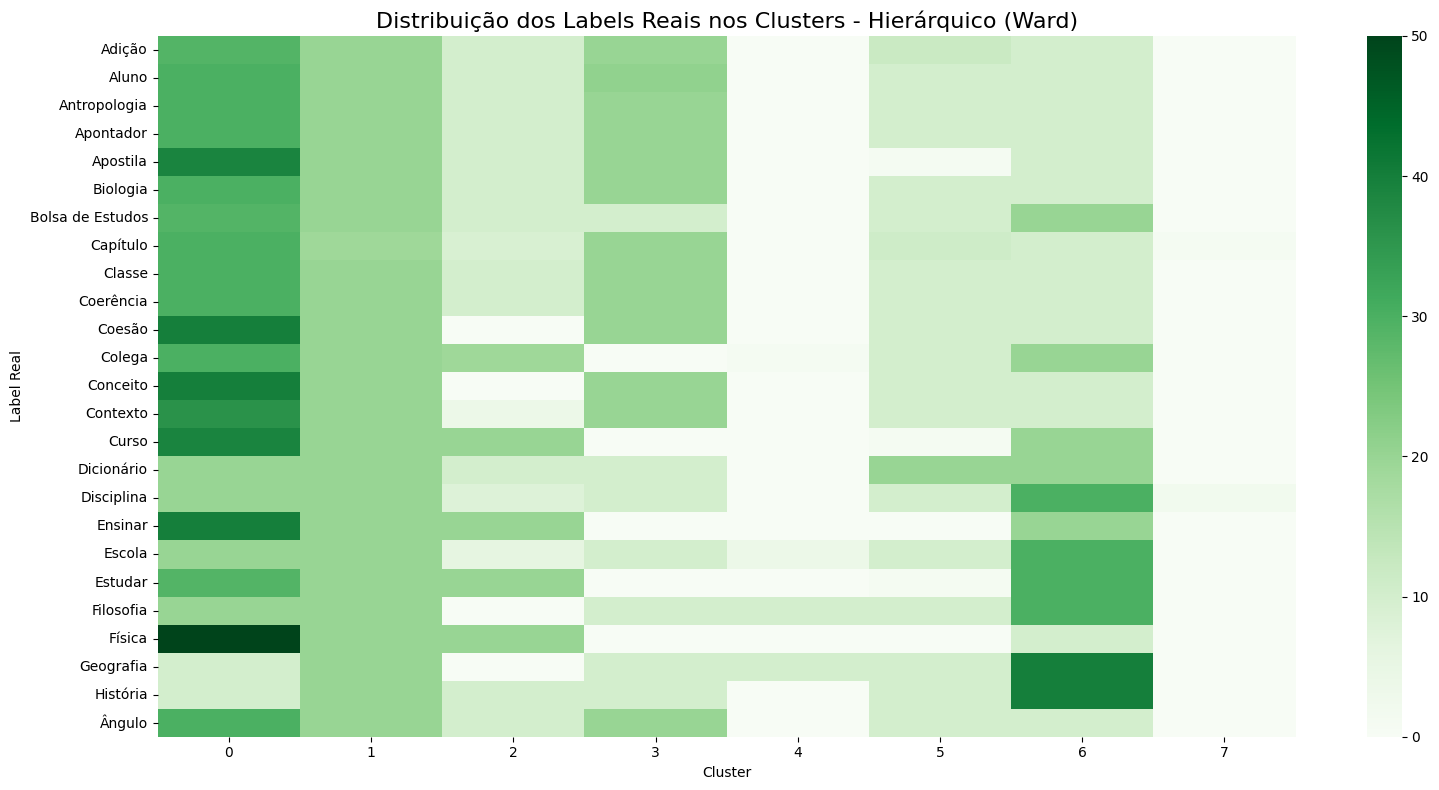

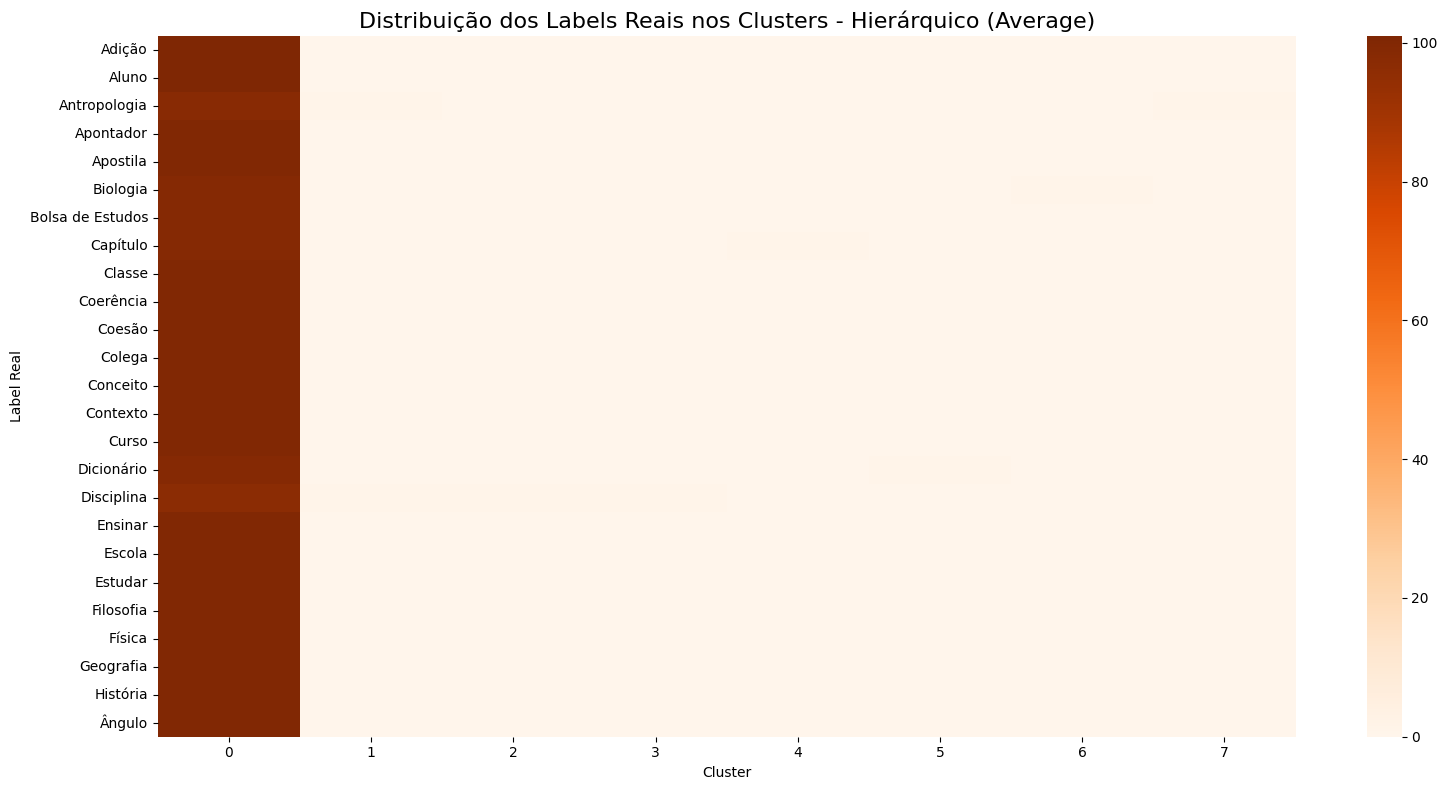

In [124]:

# Análise da distribuição dos labels reais em cada cluster

# K-means
plt.figure(figsize=(16, 8))
ct_kmeans = pd.crosstab(y, clusters_kmeans)
sns.heatmap(ct_kmeans, cmap='Blues', annot=False, fmt='d')
plt.title('Distribuição dos Labels Reais nos Clusters - K-means', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Label Real')
plt.tight_layout()
plt.show()

# Hierárquico (Ward)
plt.figure(figsize=(16, 8))
ct_ward = pd.crosstab(y, clusters_ward)
sns.heatmap(ct_ward, cmap='Greens', annot=False, fmt='d')
plt.title('Distribuição dos Labels Reais nos Clusters - Hierárquico (Ward)', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Label Real')
plt.tight_layout()
plt.show()

# Hierárquico (Average)
plt.figure(figsize=(16, 8))
ct_avg = pd.crosstab(y, clusters_average)
sns.heatmap(ct_avg, cmap='Oranges', annot=False, fmt='d')
plt.title('Distribuição dos Labels Reais nos Clusters - Hierárquico (Average)', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('Label Real')
plt.tight_layout()
plt.show()